In [1]:
# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# Algorithms
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import BaggingClassifier

# Read the data

In [2]:
test_df = pd.read_csv("./test.csv")
train_df = pd.read_csv("./train.csv")

# Data analysis

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 66.2+ KB


In [5]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Data Pre-processing

In [6]:
train_df = train_df.drop(['PassengerId'], axis=1)

# Missing data


In [7]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Fare,0,0.0
Ticket,0,0.0


### Cabin

A cabin number looks like ‘C123’ and the letter refers to the deck. Therefore I’m going to extract these and create a new feature, that contains a persons deck. Afterwords I will convert the feature into a numeric variable. The missing values will be converted to zero.

In [8]:
import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train_df, test_df]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)
# we can now drop the cabin feature
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)

### Age
I will create an array that contains random numbers, which are computed based on the mean age value in regards to the standard deviation and is_null.

In [9]:
data = [train_df, test_df]

for dataset in data:
    mean = train_df["Age"].mean()
    std = test_df["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train_df["Age"].astype(int)
train_df["Age"].isnull().sum()

0

### Embarked

In [10]:
train_df['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [11]:
common_value = 'S'
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

### Converting Features:
‘Fare’ is a float and I have to deal with 4 categorical features: Name, Sex, Ticket and Embarked.

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    int32  
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Embarked  891 non-null    object 
 10  Deck      891 non-null    int32  
dtypes: float64(1), int32(2), int64(4), object(4)
memory usage: 55.8+ KB


### Fare Fare:
Converting “Fare” from float to int64, using the “astype()” function

In [13]:
data = [train_df, test_df]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

### Name 
I extract the Titles from the Name


In [14]:
data = [train_df, test_df]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

### Sex
Convert ‘Sex’ feature into numeric

In [15]:
genders = {"male": 0, "female": 1}
data = [train_df, test_df]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

### Ticket:


In [16]:
train_df['Ticket'].describe()

count      891
unique     681
top       1601
freq         7
Name: Ticket, dtype: object

Ticket attribute has 681 unique tickets, it will be a bit tricky to convert them into useful categories. So I will drop it from the dataset.

In [17]:
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)

### Embarked
Convert ‘Embarked’ feature into numeric.

In [18]:
ports = {"S": 0, "C": 1, "Q": 2}
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

# Creating Categories

### Age
I will create the new ‘AgeGroup” variable, by categorizing every age into a group.

In [19]:
data = [train_df, test_df]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6

### Fare:
I do the same as with the ‘Age’ feature.

In [20]:
data = [train_df, test_df]

for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

# Data after Pre-processing

In [21]:
train_df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Title
0,0,3,0,2,1,0,0,0,8,1
1,1,1,1,5,1,0,3,1,3,3
2,1,3,1,3,0,0,0,0,8,2
3,1,1,1,5,1,0,3,0,3,3
4,0,3,0,5,0,0,1,0,8,1
5,0,3,0,5,0,0,1,2,8,1
6,0,1,0,6,0,0,3,0,5,1
7,0,3,0,0,3,1,2,0,8,4
8,1,3,1,3,0,2,1,0,8,3
9,1,2,1,1,1,0,2,1,8,3


# Building ML Models

In [22]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()

# Decision Tree

In [23]:
decision_tree = DecisionTreeClassifier() 
decision_tree.fit(X_train, Y_train)  
Y_pred = decision_tree.predict(X_test)  
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)

# Random Forest

In [24]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_prediction_rf = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)

# Bagging Classifier

In [25]:
clf = DecisionTreeClassifier()
bagging_clf = BaggingClassifier(base_estimator=clf, n_estimators=100,bootstrap=True, n_jobs=-1, random_state=42)
bagging_clf.fit(X_train, Y_train)

Y_prediction_bc = bagging_clf.predict(X_test)

bagging_clf.score(X_train, Y_train)
acc_bagging_clf = round(bagging_clf.score(X_train, Y_train) * 100, 2)


# K Nearest Neighbor

In [26]:
knn = KNeighborsClassifier(n_neighbors = 3) 
knn.fit(X_train, Y_train)  
Y_prediction_knn = knn.predict(X_test)  
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)

# Linear Support Vector Machine

In [27]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)

Y_pred = linear_svc.predict(X_test)

acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)

# Model Comparison

In [28]:
results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Bagging Classifier','Random Forest', 'Decision Tree'],
    'Score': [acc_linear_svc, acc_knn, acc_bagging_clf, acc_random_forest, acc_decision_tree]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head(9)

,Model
Score,
92.70,Bagging Classifier
92.70,Random Forest
92.70,Decision Tree
87.99,KNN
80.58,Support Vector Machines


# Pruning in the decision tree

In [29]:
y_test = pd.read_csv("./gender_submission.csv")
Y_test = y_test.drop("PassengerId", axis=1).copy()

In [30]:
decision_tree = DecisionTreeClassifier(random_state=0)
path = decision_tree.cost_complexity_pruning_path(X_train, Y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

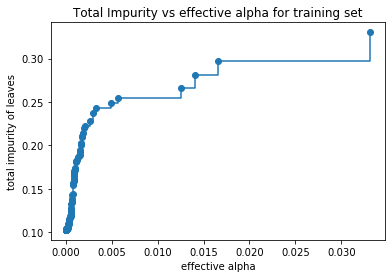

In [31]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [32]:
decision_trees = []
for ccp_alpha in ccp_alphas:
    decision_tree = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    decision_tree.fit(X_train, Y_train)
    decision_trees.append(decision_tree)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      decision_trees[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.14267004758907514


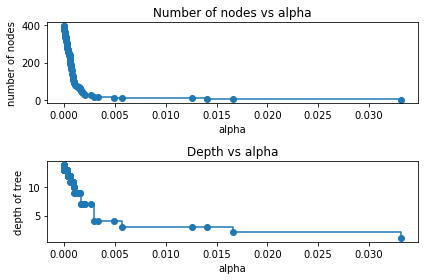

In [33]:
decision_trees = decision_trees[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [decision_tree.tree_.node_count for decision_tree in decision_trees]
depth = [decision_tree.tree_.max_depth for decision_tree in decision_trees]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

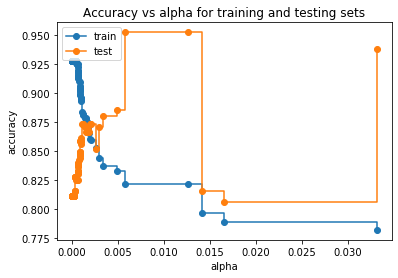

In [35]:
train_scores = [decision_tree.score(X_train, Y_train) for decision_tree in decision_trees]
test_scores = [decision_tree.score(X_test, Y_test) for decision_tree in decision_trees]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()
plt.show()